# Check Bounding Boxex NIH

In [3]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
import sys
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
import numpy as np
from ftplib import FTP
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from matplotlib import pyplot
from shapely.geometry.polygon import LinearRing, Polygon
# from multiprocessing import Pool
import multiprocessing
import time
sys.path.insert(0, os.path.dirname(os.path.abspath('.'))) # to make imports relative to project root work

First download files from ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/ to folder e.g.

NIH_NLM_ThinBloodSmears <br>
└-Point Set <br>
└-Polygon Set <br>
Notebooks <br>
└-IH_bounding_boxes.ipynb <br>

In the Terminal navigate to the folder you want your data in (**cd** then drag and drop the folder) then enter following:
wget -r -np  ftp://gdo152.ucllnl.org/cowc/datasets/ground_truth_sets


In [4]:
def get_txt(path):
    list_txt = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                txt_path = os.path.join(root, file)
                list_txt.append(txt_path)
    return list_txt


def txt_to_df(path):
    data_file_delimiter = ','
    df = pd.DataFrame(columns = [ '?','cell', 'comment', 'annotation_type','??', 'position', 'filename', 'txt_path', 'img_path'])
    root, file = os.path.split(path)
    filename, file_extension = os.path.splitext(file)
    txt_path = os.path.join(root, file)
    img_path = os.path.join(root.replace("GT", "Img"), filename +'.jpg')
    # Loop the data lines
    with open(txt_path, 'r') as temp_f:
        # Read the lines
        lines = temp_f.readlines()
        lines.pop(0)
        for l in lines:
            # Count the column count for the current line
            columns = l.split(data_file_delimiter)
            list_locations = [int(float(location)) for location in columns[5:]]
            zip_locations = list(zip(list_locations[1::2], list_locations[::2]))
            df = df.append( {'?': columns[0], 'cell': columns[1], 'comment': columns[2], 'annotation_type': columns[3], \
                '??': columns[4], 'position': zip_locations, 'filename': filename, 'txt_path': txt_path, 'img_path': img_path}, ignore_index = True)
    return df

def collect_results(df_collected):
    """Uses apply_async's callback to setup up a separate Queue for each process"""
    global df
    df = df.append(df_collected)


In [28]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def draw_points(img, cell, annotation, position):
    colour = (0,255,0) if cell == 'Uninfected' \
        else (255,0, 0) if cell == 'Parasitized' \
            else (128,0, 128) if cell == 'Platelet' \
                else (0, 0, 255) if cell == 'White_Blood_Cell' \
                    else (255,215,0)
                    
    if annotation == 'Point':
        cv2.circle(img, position[0], 1, colour, 15)
    
    elif annotation == 'Polygon':
        poly = Polygon(position)
        x,y = poly.exterior.xy
        ax = fig.add_subplot(111)
        ax.plot(x, y, color=rgb_to_hex(colour), alpha=0.7,
            linewidth=3, solid_capstyle='round', zorder=2)

In [29]:
txt_list = get_txt('../NIH-NLM-ThinBloodSmearsPf/')
print(len(txt_list))

965


**The following operation takes a while lean back and get a coffee**

In [30]:
df = pd.DataFrame(columns = [ '?','cell', 'comment', 'annotation_type','??', 'position', 'filename', 'txt_path', 'img_path'])
start_time = time.time()  

# Repeats the compute intensive operation on all available cores
pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
pool.map_async(txt_to_df, txt_list, callback = collect_results)
pool.close()
pool.join()

# Converts list of lists to a data frame
print(df.shape)
print("--- %s seconds ---" % (time.time() - start_time))

(250570, 9)
--- 200.77634501457214 seconds ---


In [31]:
df

,?,cell,comment,annotation_type,??,position,filename,txt_path,img_path
0,1-208,White_Blood_Cell,No_comment,Polygon,23,"[(1816, 1753), (1820, 1779), (1834, 1808), (18...",IMG_20150918_161508,../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...,../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...
1,1-1,Parasitized,No_Comment,Point,1,"[(1302, 2470)]",IMG_20150918_161508,../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...,../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...
2,1-10,Stain_Precipitation,No_Comment,Point,1,"[(1156, 3535)]",IMG_20150918_161508,../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...,../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...
3,1-100,Uninfected,No_Comment,Point,1,"[(944, 1598)]",IMG_20150918_161508,../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...,../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...
4,1-101,Uninfected,No_Comment,Point,1,"[(987, 1756)]",IMG_20150918_161508,../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...,../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...
...,...,...,...,...,...,...,...,...,...
362,4-95,Uninfected,No_Comment,Point,1,"[(1491, 1648)]",IMG_20151004_131030,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...
363,4-96,Uninfected,No_Comment,Point,1,"[(1557, 2121)]",IMG_20151004_131030,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...
364,4-97,Uninfected,No_Comment,Point,1,"[(924, 1654)]",IMG_20151004_131030,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...
365,4-98,Uninfected,No_Comment,Point,1,"[(1003, 1527)]",IMG_20151004_131030,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...


In [32]:
# df = pd.read_csv(gt_path, sep = ',', header = 0, names= [ '?','cell', 'comment', 'annotation_type','??', 'y', 'x'])
df['cell'].value_counts()

Uninfected               229046
Parasitized               10673
Other                      4143
Platelet                   4033
Stain_Precipitation        1078
White_Blood_Cell            542
Debris                      337
Bacteria                    254
Parasite_Outside_Cell       251
Unclear                     111
Dead_Parasite                58
Air_Bubble                   35
Gametocyte                    9
Name: cell, dtype: int64

In [33]:
filename =  'IMG_20150621_112043'
df_file = df[df['filename'] == filename]

In [34]:
df_file

,?,cell,comment,annotation_type,??,position,filename,txt_path,img_path
0,2-212,Parasitized,No_comment,Polygon,14,"[(1426, 3624), (1407, 3603), (1398, 3582), (13...",IMG_20150621_112043,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...
1,2-213,Parasitized,No_comment,Polygon,11,"[(1284, 1446), (1301, 1473), (1307, 1498), (12...",IMG_20150621_112043,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...
2,2-215,Uninfected,No_comment,Polygon,11,"[(1541, 2916), (1517, 2951), (1491, 2960), (14...",IMG_20150621_112043,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...
3,2-216,Uninfected,No_comment,Polygon,12,"[(1569, 3007), (1551, 2987), (1516, 2982), (14...",IMG_20150621_112043,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...
4,2-217,Uninfected,No_comment,Polygon,10,"[(1788, 3104), (1782, 3128), (1720, 3166), (16...",IMG_20150621_112043,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...
...,...,...,...,...,...,...,...,...,...
413,2-95,Uninfected,No_Comment,Point,1,"[(1027, 1873)]",IMG_20150621_112043,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...
414,2-96,Uninfected,No_Comment,Point,1,"[(1127, 1873)]",IMG_20150621_112043,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...
415,2-97,Uninfected,No_Comment,Point,1,"[(1051, 1664)]",IMG_20150621_112043,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...
416,2-98,Uninfected,No_Comment,Point,1,"[(1124, 1597)]",IMG_20150621_112043,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...,../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...


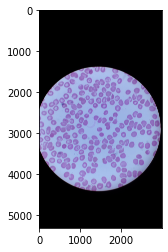

In [35]:
img = cv2.imread(df_file['img_path'][0], cv2.IMREAD_COLOR)
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img = cv2.flip(img, 1)
plt.imshow(img)

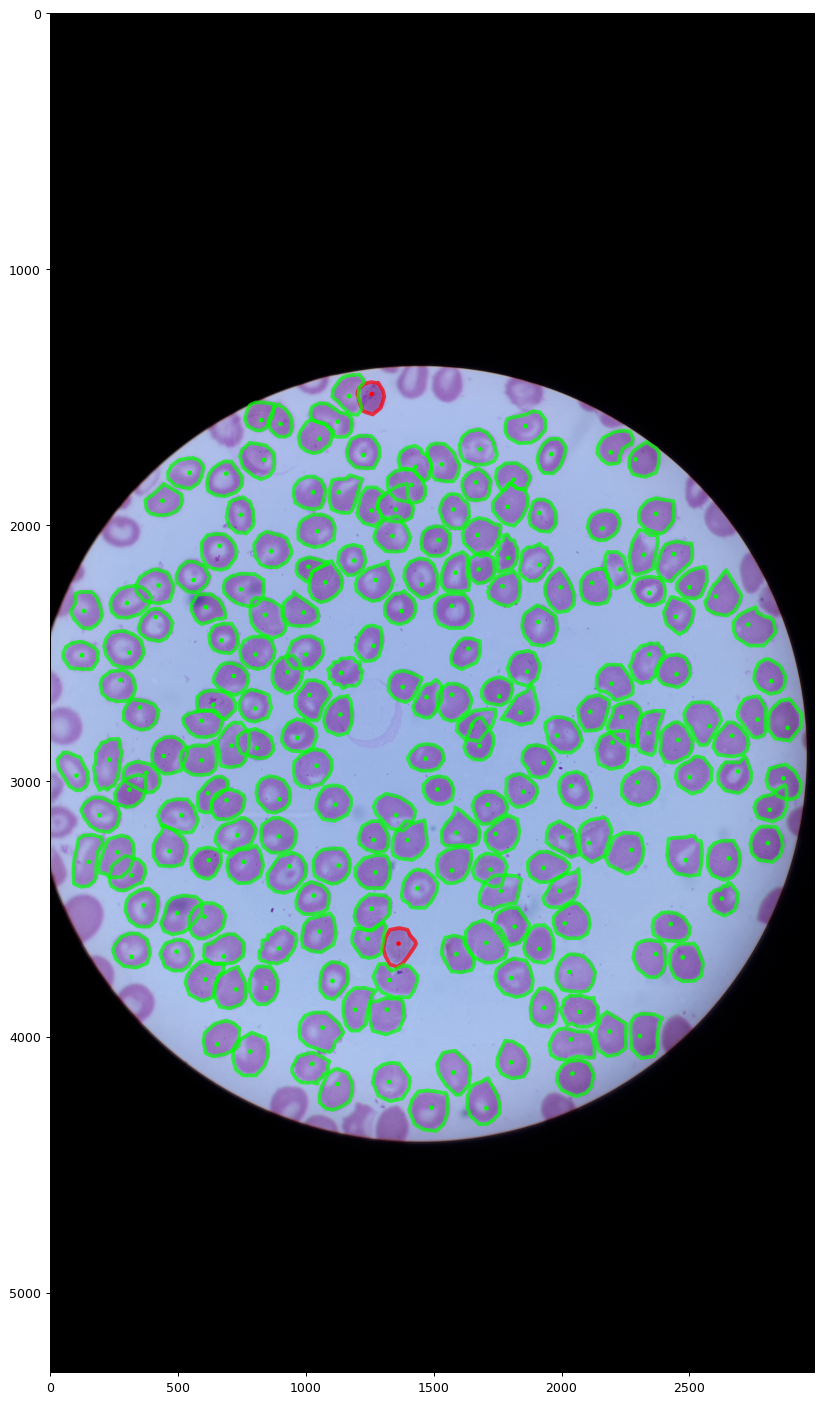

In [36]:
fig = plt.figure(1, figsize=(20,20), dpi=90)
df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position']), axis = 1)
plt.imshow(img)